<a href="https://colab.research.google.com/github/JakubPyt/Tabular_Playground_Series-Apr_2021/blob/main/Tabular_Playground_Series_Apr_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comments and explanations

This notebook was created for competition on Kaggle website.

Full description is at the link:

https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview

In short: 
- **This is NOT popular dataset about Titanic passengers.**
- Kaggle give us expanded dataset based on Titanic dataset, but in this case there is no way to cheat by using public labels or predictions.
- Our goal is to predict which passenger survived.

**Caution:** I joined this contest late, and most of my submissions were "Late Submission". Therefore the result on screen in the end of this notebook doesn't coincide with my results on leaderborad(only the results before the deadline are recorded in the leaderboard).

Let's start!

# Imports

Let's start from import needed libraries and of course - data.

In [1158]:
# Import basic modules
import pandas as pd
import numpy as np

# Import modules for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.express as px

# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Import other tools for models
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix


url_train = 'https://raw.githubusercontent.com/JakubPyt/Tabular_Playground_Series-Apr_2021/main/train.csv'
url_test = 'https://raw.githubusercontent.com/JakubPyt/Tabular_Playground_Series-Apr_2021/main/test.csv'
url_sample_submission = 'https://raw.githubusercontent.com/JakubPyt/Tabular_Playground_Series-Apr_2021/main/sample_submission.csv'

dataset_basic = pd.read_csv(url_train)

# Inspect the data

Let's see what we have in basic dataset:

In [1159]:
dataset_basic.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
99995,99995,1,2,"Bell, Adele",female,62.0,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.0,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.0,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.0,0,1,458654,30.92,NaN,S
99999,99999,0,3,"Enciso, Tyler",male,55.0,0,0,458074,13.96,NaN,S


Seeing only the last five rows of dataset, we know that we will have to clear dataset from NaN values. Let's see how many we have:



In [1160]:
dataset_basic.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

Quite a few... Ok, we will back to this. 

Let's take a look at datatypes:

In [1161]:
dataset_basic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

This is important information that we will use later.

Now, let's focus on the categorical data in our dataset. Code below print values from columns if there is no more than 10 unique values. If more than 10, code print how many diffrent values are in column.

In [1162]:
for column in dataset_basic:
    if dataset_basic[column].nunique() < 10:
        print(column, "=", pd.unique(dataset_basic[column]))
    else:
        print(column, "have", dataset_basic[column].nunique(), "different values.")

PassengerId have 100000 different values.
Survived = [1 0]
Pclass = [1 3 2]
Name have 92144 different values.
Sex = ['male' 'female']
Age have 173 different values.
SibSp = [2 0 1 3 4 8 5]
Parch = [0 2 1 4 3 5 6 9]
Ticket have 75331 different values.
Fare have 15935 different values.
Cabin have 26992 different values.
Embarked = ['S' 'C' 'Q' nan]


Summarizing the information from previous cells I think that we don't need some columns, but we will take a look for this in next parts of this notebook.

Let's go further to numeric data.

In [1163]:
dataset_basic.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,100000.0,49999.500000,28867.657797,0.00,24999.75,49999.50,74999.25,99999.00
Survived,100000.0,0.427740,0.494753,0.00,0.00,0.00,1.00,1.00
Pclass,100000.0,2.106910,0.837727,1.00,1.00,2.00,3.00,3.00
Age,96708.0,38.355472,18.313556,0.08,25.00,39.00,53.00,87.00
SibSp,100000.0,0.397690,0.862566,0.00,0.00,0.00,1.00,8.00
Parch,100000.0,0.454560,0.950076,0.00,0.00,0.00,1.00,9.00
Fare,99866.0,43.929330,69.588820,0.68,10.04,24.46,33.50,744.66


Next information: We will have to normalize column 'Fare' and 'Age'.

Summarizing information from this section I think that best way to prepare this dataset is walk over all the columns and take appropriate action.

# Column by column - explore, clean and prepapare

In [1164]:
dataset_prepare = dataset_basic.copy()

## Auxiliary functions

Why write more code when we can write less code? Let's define functions that will help us limit lines of code.

In [1165]:
def survivors_by_category(column, dataset):
    """
    Function grouped dataset by specific column and show plot with values from 
    this column divided according to the values in the column 'Survived'.
    :column: string - name of the column
    :dataset: pandas DataFrame
    """
    dataset_visualisation = (
        dataset
        .groupby(column)['Survived']
        .value_counts(normalize=True)
        .unstack()
        .melt(ignore_index=False)
        .reset_index()
    )
    sns.set_theme(style="whitegrid")
    
    g = sns.catplot(
        data=dataset_visualisation,
        kind='bar',
        x=column,
        y='value',
        hue='Survived',
        palette="dark",
        alpha=.6,   
    )
    g.set(title=f"Survivors by {column}")
    g.despine(left=True)
    plt.show()

In [1166]:
def value_counts_pie(column, dataset):
    """
    Function show pie chart for values from specific column from dataset.
    :column: string - name of the column
    :dataset: pandas DataFrame
    """
    plt.figure(figsize=(10,5))

    dataset[column].value_counts(normalize=True).plot(
        kind='pie',
        autopct='%1.1f%%',
        cmap=plt.get_cmap('summer')
    )
    plt.ylabel('')
    plt.title(f"Values in {column}", fontsize=18)
    plt.show()

In [1167]:
def info_about_column(column, dataset):
    """
    Function return information about column:
     - Number of NaN values
     - Number of unique values
     - Data type of column
    :column: string - nam of the column
    :dataset: pandas DataFrame 
    """
    print(column.center(60, "."))
    print("NaN: |".rjust(30, " "), dataset[column].isnull().sum())
    print("Values: |".rjust(30, " "), dataset[column].nunique(), "different values.")
    print("Dtype: |".rjust(30, " "), dataset[column].dtypes)

## PassengerId

I didn't set this column for index of the dataset, because I know that it could generate problems with training model, so now we can simply drop this column.

In [1168]:
dataset_prepare = dataset_prepare.drop(['PassengerId'], axis=1)

## Survived

Our labels.
Values:
 - 0 - if not survived
 - 1 - if survived

In [1169]:
info_about_column("Survived", dataset_prepare)

..........................Survived..........................
                        NaN: | 0
                     Values: | 2 different values.
                      Dtype: | int64


Now check values and their percentage in values in this column.

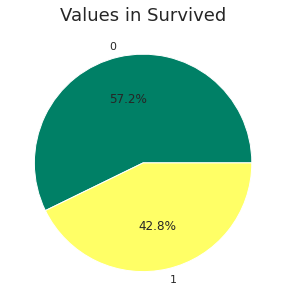

In [1170]:
value_counts_pie('Survived', dataset_prepare)

0 means that passenger doesn't survived, and 1 that survived.

Now we know that more than 50% passengers didn't survived. 

In other words: The passenger is more likely not to survive than survive.

## Fare

Passenger fare.

In [1171]:
info_about_column("Fare", dataset_prepare)

............................Fare............................
                        NaN: | 134
                     Values: | 15935 different values.
                      Dtype: | float64


As we can see, we have 133 NaN values in this column. But we don't want to delete rows. So let's replace NaN values with median from this column.

In [1172]:
dataset_prepare['Fare'].replace({np.nan: np.nanpercentile(dataset_prepare['Fare'], 50) }, inplace=True)
dataset_prepare['Fare'].isnull().sum()

0

Let's look denisity plot of Fare.

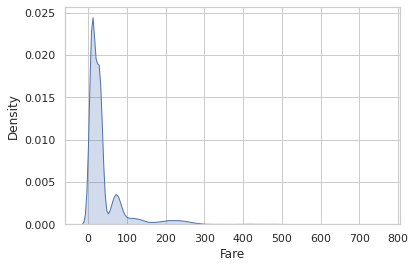

In [1173]:
sns.kdeplot(
    dataset_prepare['Fare'],
    shade=True
)

Now we can see how 'Fare' affects survivability. 

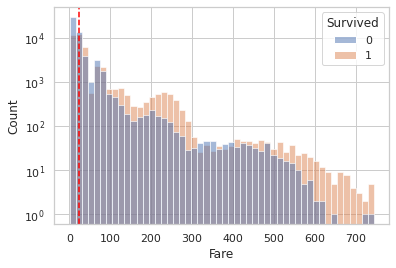

In [1174]:
g = sns.histplot(
    data=dataset_prepare,
    x="Fare",
    hue='Survived',
    bins=50,
)
plt.axvline(np.median(dataset_prepare['Fare']), linestyle='dashed', c='red')
plt.yscale('log')

As we can see - if you paid more, you have bigger chance to survive.

Only single cases from rich people didn't survive. This cases will interfere with the operation of the model. So we will delete them, but not now.


In [1175]:
print(
    "No. passengers who paid >585 and NOT survived:",
    dataset_prepare[(dataset_prepare['Fare'] > 585) & (dataset_prepare['Survived'] == 0)].shape[0]
)
print(
    "No. passengers who paid >585 and survived:",
    dataset_prepare[(dataset_prepare['Fare'] > 585) & (dataset_prepare['Survived'] == 1)].shape[0]
)

No. passengers who paid >585 and NOT survived: 11
No. passengers who paid >585 and survived: 84


We also know that we have to normalize this column. But we will do this later.



## Age 

Age in years.

In [1176]:
info_about_column("Age", dataset_prepare)

............................Age.............................
                        NaN: | 3292
                     Values: | 173 different values.
                      Dtype: | float64


We have a lot of NaN values, so we don't want to lose their. Let's see description of this column.

In [1177]:
dataset_prepare[['Age']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,96708.0,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0


I think that we could replace all NaN values with median.

In [1178]:
dataset_prepare['Age'].replace({np.nan: np.nanpercentile(dataset_prepare['Age'], 50) }, inplace=True)
dataset_prepare['Age'].isnull().sum()

0

Now we can display denisity plot of Age.

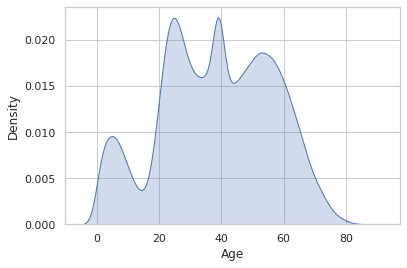

In [1179]:
sns.kdeplot(
    dataset_prepare['Age'],
    shade=True,
)

And how 'Age' affects 'Survived' column.

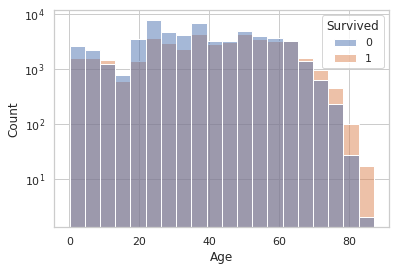

In [1180]:
g = sns.histplot(
    data=dataset_prepare,
    x="Age",
    hue='Survived',
    bins=20,
)
plt.yscale('log')

Now we can see that the old people have bigger survivability. And this make sense - old people(with women and kids) first were entering to emergency cabins. 

So we only must remember to normalize this column later.

Now we can display dependece Age, Fare and Survived.

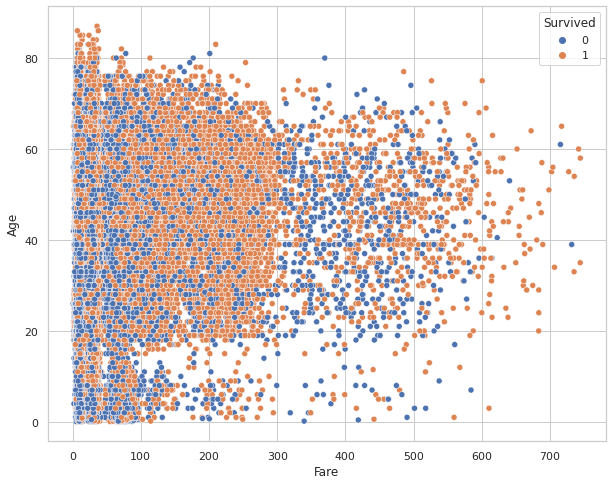

In [1181]:
plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=dataset_prepare,
    x='Fare',
    y='Age',
    hue='Survived'
)

The same situation what in Fare...

In [1182]:
print(
    "No. passengers with age >81 and NOT survived:",
    dataset_prepare[(dataset_prepare['Age'] > 81) & (dataset_prepare['Survived'] == 0)].shape[0]
)
print(
    "No. passengers who paid >81 and survived:",
    dataset_prepare[(dataset_prepare['Age'] > 81) & (dataset_prepare['Survived'] == 1)].shape[0]
)

No. passengers with age >81 and NOT survived: 4
No. passengers who paid >81 and survived: 24


## Pclass

That column tell us in which status class passenger was traveled.

In [1183]:
info_about_column("Pclass", dataset_prepare)

...........................Pclass...........................
                        NaN: | 0
                     Values: | 3 different values.
                      Dtype: | int64


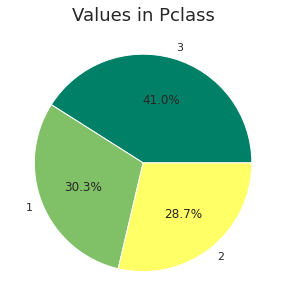

In [1184]:
value_counts_pie('Pclass', dataset_prepare)

Let's see how many passengers in each class survived.

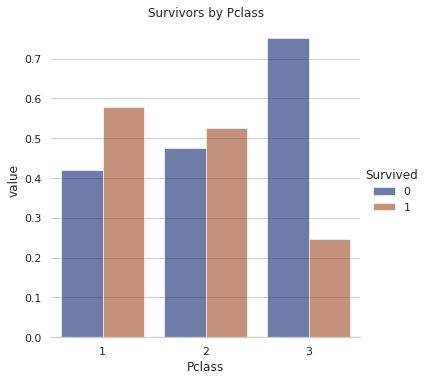

In [1185]:
survivors_by_category('Pclass', dataset_prepare)

Now we can see that in third class were the most passengers, but also in class 3 most of passengers didn't survived.

But in class 1 and 2(smaller in number), more than 50% passengers survived.

And one more plot.

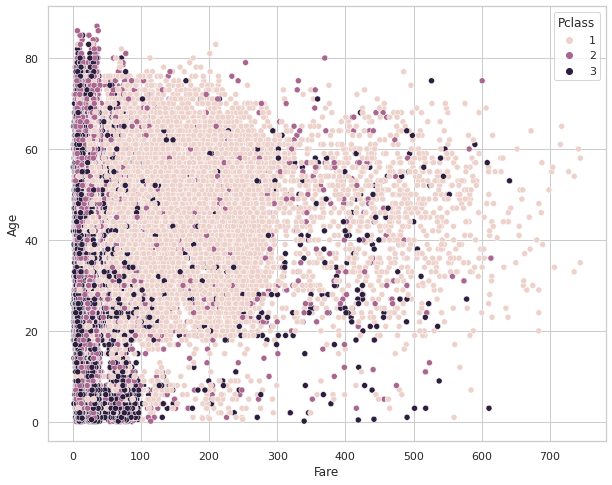

In [1186]:
plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=dataset_basic,
    x='Fare',
    y='Age',
    hue='Pclass'
)

Last step in this column is decompose this column into 3 other columns.

In [1187]:
dataset_prepare = pd.get_dummies(
    dataset_prepare,
    columns=['Pclass']
)

## Name

Let's take a look for information about this column.

In [1188]:
info_about_column("Name", dataset_prepare)

............................Name............................
                        NaN: | 0
                     Values: | 92144 different values.
                      Dtype: | object


This column is clear of the NaN values, but I don't think the passenger name will determine whether or not he will survive. So we can just drop this column.

In [1189]:
dataset_prepare = dataset_prepare.drop(['Name'], axis=1)

## Sex

Information about this column:

In [1190]:
info_about_column("Sex", dataset_prepare)

............................Sex.............................
                        NaN: | 0
                     Values: | 2 different values.
                      Dtype: | object


Sector clear, we can go ahead. Values:

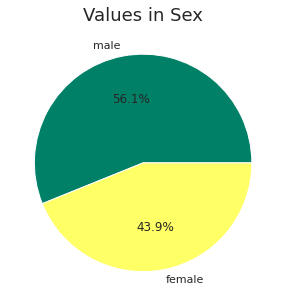

In [1191]:
value_counts_pie('Sex', dataset_prepare)

And which value was more likely to survive?

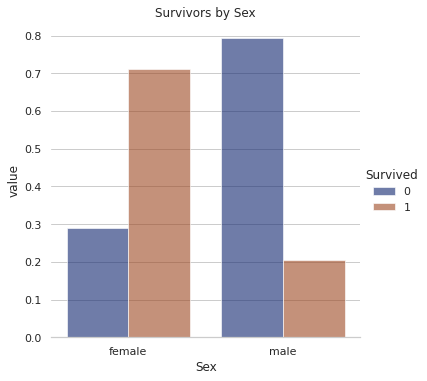

In [1192]:
survivors_by_category('Sex', dataset_prepare)

The women had more likely to survive. This is important column. But let's make it more accessible to the model:

In [1193]:
dataset_prepare['Sex'] = dataset_prepare['Sex'].map({
    'female': 1, 
    'male': 0
})

Now:
 - 0 is male
 - 1 is female

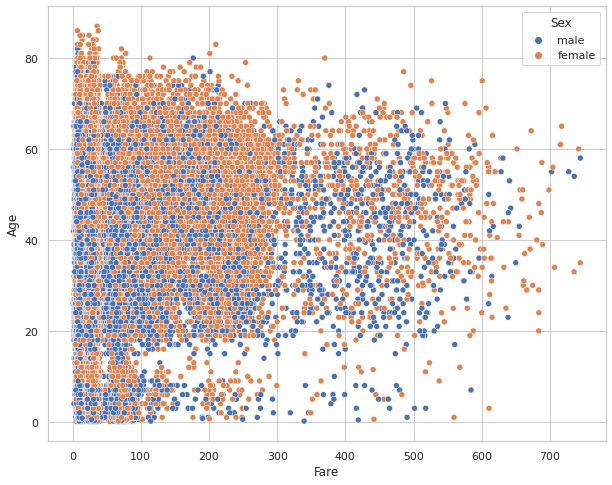

In [1194]:
plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=dataset_basic,
    x='Fare',
    y='Age',
    hue='Sex'
)

## Parch 

This column represents number of parents and children on board. 

In [1195]:
info_about_column("Parch", dataset_prepare)

...........................Parch............................
                        NaN: | 0
                     Values: | 8 different values.
                      Dtype: | int64


Now, what about the values?

I like pie charts, but in this case my function doesn't work well, so I was used other Python library to display pie chart.



In [1196]:
fig = px.pie(
    dataset_prepare,
    values=dataset_prepare[['Parch']].value_counts(),
    names=dataset_prepare['Parch'].value_counts().index,
    title="Values in Parch"
)

fig.show()

Ok, now let's see how column 'Parch' affects column 'Survived'.

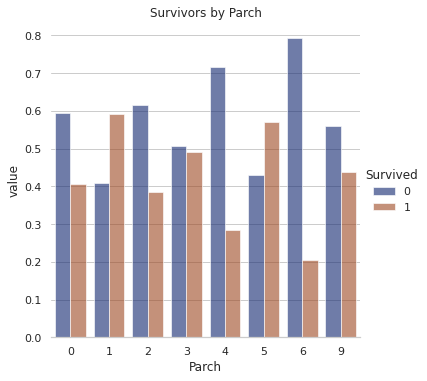

In [1197]:
survivors_by_category('Parch', dataset_prepare)

I think there is no point in introducing a rule that "if you have five family members(parents and children) on board, you wil survive, but if you have four family members, you die". It doesn't make sense. 

I think that we could change values in this column into 3 values:
 - 0 - if you have 0 family members on board
 - 1 - if you have 1 family member on board(group first of all for mothers and children, that have more survivability in emergency cabins)
 - 2 - for others

In [1198]:
dataset_prepare['Parch'] = dataset_prepare['Parch'].map({
    0: 0, 
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 2,
    6: 2,
    9: 2,
})

Let's see what we have now:

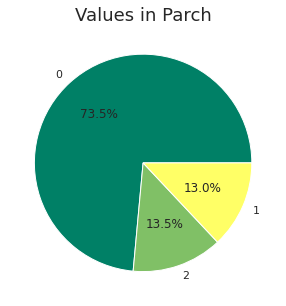

In [1199]:
value_counts_pie('Parch', dataset_prepare)

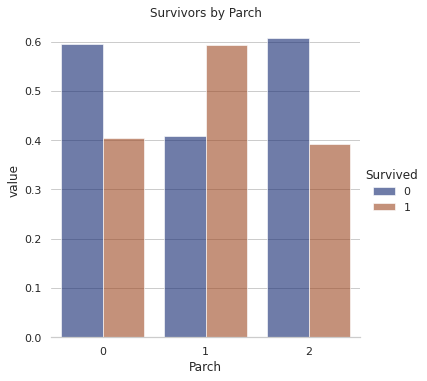

In [1200]:
survivors_by_category('Parch', dataset_prepare)

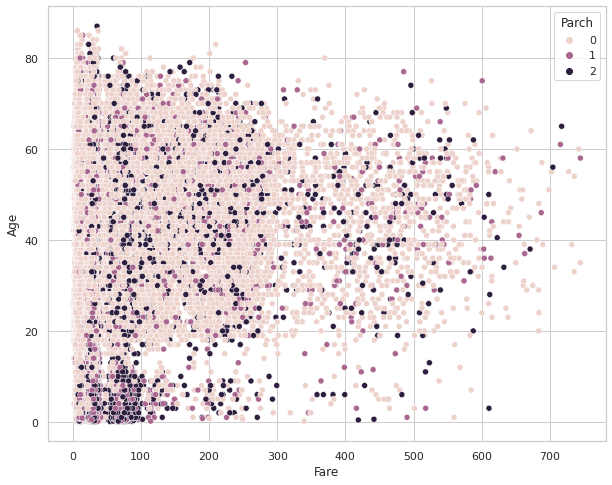

In [1201]:
plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=dataset_prepare,
    x='Fare',
    y='Age',
    hue='Parch'
)

After analysis, we can decompose this column.

In [1202]:
dataset_prepare = pd.get_dummies(
    dataset_prepare,
    columns=['Parch']
)

## SibSp 

This column represents number of siblings and spouses on board.

In [1203]:
info_about_column("SibSp", dataset_prepare)

...........................SibSp............................
                        NaN: | 0
                     Values: | 7 different values.
                      Dtype: | int64


Let's see what about the values.

The same as in the previous section about pie charts.

In [1204]:
fig = px.pie(
    dataset_prepare,
    values=dataset_prepare[['SibSp']].value_counts(),
    names=dataset_prepare['SibSp'].value_counts().index,
    title="Values in SibSp"
)

fig.show()

And values relative to the column 'Survived'. 

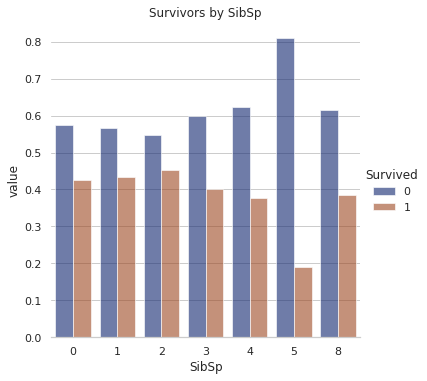

In [1205]:
survivors_by_category('SibSp', dataset_prepare)

In this case no matter how many siblings and spouses you have on board. You will die. 

And on logic - there was confusion at the emergency cabins and chances was slim to help your siblings and spouses to enter to emergency cabins. Crowd next to emergency cabins was your new siblings and spouses. I think that we can drop this column.

In [1206]:
dataset_prepare.drop(['SibSp'], axis=1, inplace=True)

## Ticket 

This column represents ticket number.

In [1207]:
info_about_column("Ticket", dataset_prepare)

...........................Ticket...........................
                        NaN: | 4623
                     Values: | 75331 different values.
                      Dtype: | object


Many different object values and "a few" missing values. I think we can drop this column.

In [1208]:
dataset_prepare = dataset_prepare.drop(['Ticket'], axis=1)

## Cabin

This column represents cabin number in which passenger has traveled.

In [1209]:
info_about_column("Cabin", dataset_prepare)

...........................Cabin............................
                        NaN: | 67866
                     Values: | 26992 different values.
                      Dtype: | object


First letter from this cabin number show us, in which deck passenger was traveled. It could be important information. Let's get it.

In [1210]:
# First replace all missing values with M like Missing
dataset_prepare['Cabin'] = dataset_prepare['Cabin'].replace({np.nan : "M"})

# Now, take first letter from each row and set it as value 
dataset_prepare['Cabin'] = dataset_prepare['Cabin'].astype(str).str[0]

# And take info about new values in column
info_about_column("Cabin", dataset_prepare)

...........................Cabin............................
                        NaN: | 0
                     Values: | 9 different values.
                      Dtype: | object


Now we can explore this column.

In [1211]:
fig = px.pie(
    dataset_prepare,
    values=dataset_prepare[['Cabin']].value_counts(),
    names=dataset_prepare['Cabin'].value_counts().index,
    title="Values in Cabin"
)

fig.show()

The dependence of the survival rate on the cabin.

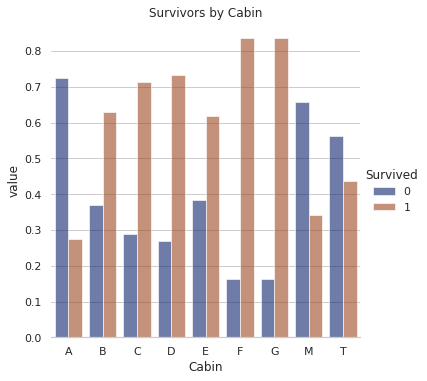

In [1212]:
survivors_by_category('Cabin', dataset_prepare)

The dependence of the fare on the cabin.

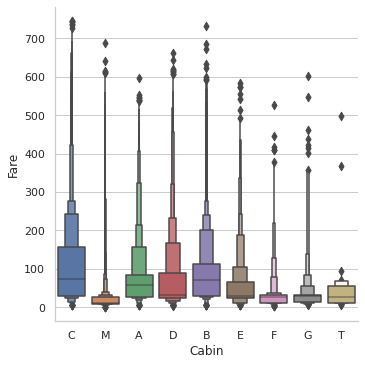

In [1213]:
sns.catplot(
    data=dataset_prepare,
    x='Cabin',
    y='Fare',
    kind='boxen'
)

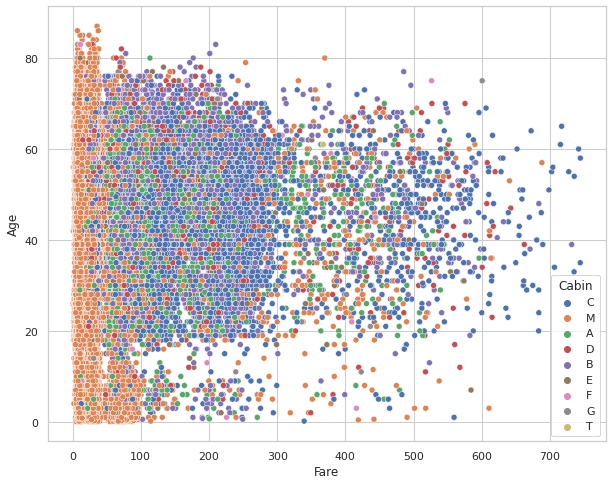

In [1214]:
plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=dataset_prepare,
    x='Fare',
    y='Age',
    hue='Cabin'
)

When we explore this column, we can conclude that we have too many missing values in this column to use it well. So we drop it.

In [1215]:
dataset_prepare = dataset_prepare.drop(['Cabin'], axis=1)

## Embarked

Port of Embarkation:
 - C = Cherbourg, 
 - Q = Queenstown, 
 - S = Southampton.

In [1216]:
info_about_column("Embarked", dataset_prepare)

..........................Embarked..........................
                        NaN: | 250
                     Values: | 3 different values.
                      Dtype: | object


We have NaN values here, and we don't want to delete rows, so we replace NaN values with "M" like "Missing".

In [1217]:
dataset_prepare['Embarked'].replace({np.nan : "M"}, inplace=True)
dataset_prepare['Embarked'].isnull().sum()

0

Now we can go to values from this column.

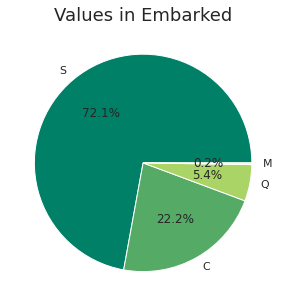

In [1218]:
value_counts_pie('Embarked', dataset_prepare)

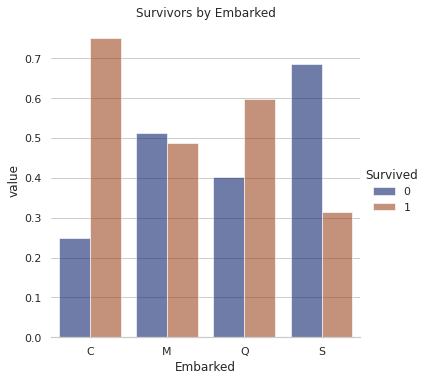

In [1219]:
survivors_by_category('Embarked', dataset_prepare)

Here we see that port of embarkation matters. 

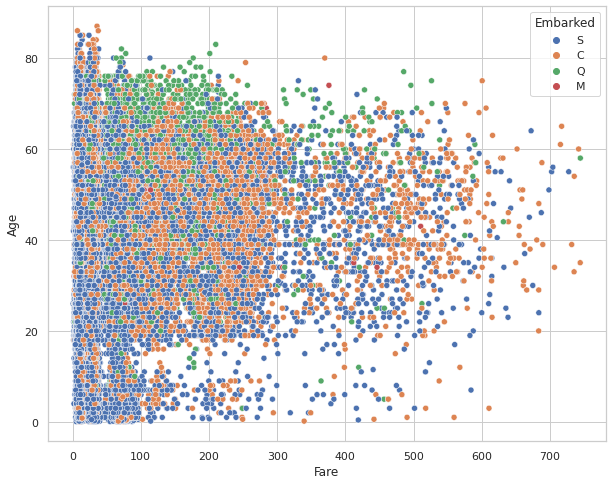

In [1220]:
plt.subplots(figsize=(10,8))
sns.scatterplot(
    data=dataset_prepare,
    x='Fare',
    y='Age',
    hue='Embarked'
)



So now, let's decompose this column to other form.

In [1221]:
dataset_prepare = pd.get_dummies(
    dataset_prepare,
    columns=['Embarked']
)

# Explore full dataset

This is how now our dataset looks like:

In [1222]:
dataset_prepare.tail()

,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Embarked_C,Embarked_M,Embarked_Q,Embarked_S
99995,1,1,62.0,14.86,0,1,0,1,0,0,1,0,0,0
99996,0,0,66.0,11.15,0,1,0,1,0,0,0,0,0,1
99997,0,0,37.0,9.95,0,0,1,1,0,0,0,0,0,1
99998,0,0,51.0,30.92,0,0,1,0,1,0,0,0,0,1
99999,0,0,55.0,13.96,0,0,1,1,0,0,0,0,0,1


In [1223]:
dataset_prepare.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Survived,100000.0,0.427740,0.494753,0.00,0.00,0.00,1.00,1.00
Sex,100000.0,0.438860,0.496250,0.00,0.00,0.00,1.00,1.00
Age,100000.0,38.376690,18.009956,0.08,25.00,39.00,53.00,87.00
Fare,100000.0,43.903241,69.545827,0.68,10.04,24.46,33.47,744.66
Pclass_1,100000.0,0.303150,0.459622,0.00,0.00,0.00,1.00,1.00
Pclass_2,100000.0,0.286790,0.452265,0.00,0.00,0.00,1.00,1.00
Pclass_3,100000.0,0.410060,0.491847,0.00,0.00,0.00,1.00,1.00
Parch_0,100000.0,0.735400,0.441122,0.00,0.00,1.00,1.00,1.00
Parch_1,100000.0,0.129960,0.336261,0.00,0.00,0.00,0.00,1.00
Parch_2,100000.0,0.134640,0.341340,0.00,0.00,0.00,0.00,1.00


Let's generate correlation matrix. Maybe we'll learn something new.

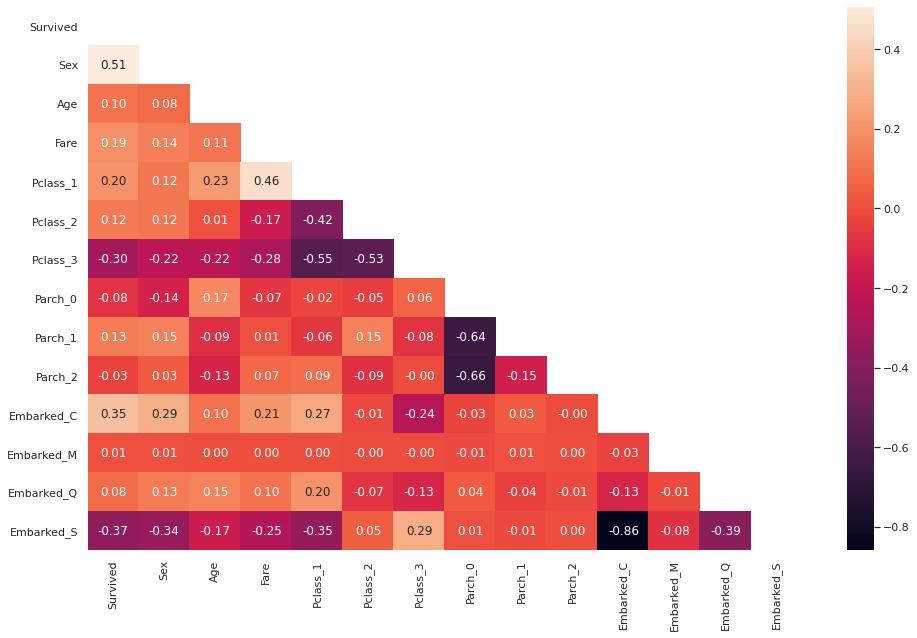

In [1224]:
f = plt.subplots(figsize=(16, 10))
mask = np.zeros_like(dataset_prepare.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_prepare.corr(), annot=True, mask=mask, fmt='.2f')

I think that we can drop column with the lowest correlation with column 'Survived'.

In [1225]:
dataset_prepare = dataset_prepare.drop(['Embarked_M'], axis=1)

# Model selection

When we have prepared data, we could go ahead. Our next goal is to chose best model for our dataset.

But first of all, we should take part of the data and split it into labels(y) and features(X).

In [1247]:
# First of all, make a copy of our dataset
dataset_ms = dataset_prepare.copy() 

# We don't need the entire dataset
# Let's take only 10 000 random rows from dataset
dataset_ms = dataset_ms.sample(n=10_000)

# Without this line, we will have a bug with model fitting
dataset_ms = dataset_ms.reset_index(drop=True)

# Labels
y = dataset_ms.pop('Survived')  

# Features
X = dataset_ms.values  

For this test I chose three most useful models for this kind of problem.

Models:
 - Random Forest
 - Logistic Regression
 - MLPClassifier(Neural Network)

All of above have defult sets.

************************Mean accurancy scores*************************
Random Forest: 0.7228
Logistic Regression: 0.7634000000000001
Neural Network: 0.7623

***************************Accurancy scores***************************
   Random Forest  Logistic Regression  Neural Network
0         0.7260               0.7720          0.7745
1         0.7110               0.7590          0.7425
2         0.7270               0.7585          0.7655
3         0.7235               0.7660          0.7580
4         0.7265               0.7615          0.7710



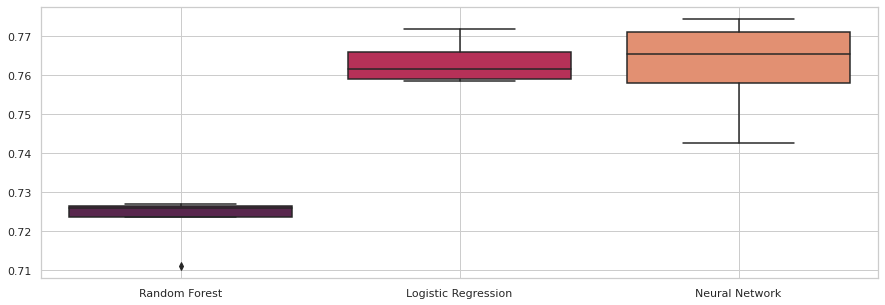

In [1248]:
# Create instance of KFold
kf = KFold(n_splits=5, shuffle=True)

# Create lists for results each of model
accuracy_scores_rf = []
accuracy_scores_lr = []
accuracy_scores_mlp = []

# For loop will be done 5 times
for train_index, test_index in kf.split(X):
    # Every time with new data
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    # Let's create an instace of scaler and fit it to X_train data
    scaler = preprocessing.StandardScaler().fit(X_train)

    # Now we can transform dataset with normalized values
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) 

    # ============= #
    # Random Forest #
    # ============= #
    rf = RandomForestClassifier()  # Create instance of model
    rf.fit(X_train, y_train)  # Train the model
    y_pred_rf = rf.predict(X_test)  # Predict values
    accuracy_scores_rf.append(accuracy_score(y_test, y_pred_rf))  # Save the results

    # =================== #
    # Logistic Regression #
    # =================== #
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    accuracy_scores_lr.append(accuracy_score(y_test, y_pred_lr))
    
    # =============== #
    # Neural Networks #
    # =============== #
    mlp = MLPClassifier(max_iter=1000)
    mlp.fit(X_train, y_train)
    y_pred_mlp = mlp.predict(X_test)
    accuracy_scores_mlp.append(accuracy_score(y_test, y_pred_mlp))

# ===================== #
# Print results section #
# ===================== #
# Print mean accurancy scores
print("Mean accurancy scores".center(70, "*"))
print("Random Forest:", np.mean(accuracy_scores_rf))
print("Logistic Regression:", np.mean(accuracy_scores_lr))
print("Neural Network:", np.mean(accuracy_scores_mlp))
print()

# Create dataframe from lists of restults
all_scores = {
    'Random Forest': accuracy_scores_rf,
    'Logistic Regression': accuracy_scores_lr,
    'Neural Network': accuracy_scores_mlp
}
df_results = pd.DataFrame(all_scores, columns=all_scores.keys())

# Print dataframe
print("Accurancy scores".center(70, "*"))
print(df_results)
print()

# Display a boxplots
plt.figure(figsize=(15,5))
sns.boxplot(data=df_results, palette="rocket",)
plt.grid(True)
plt.show()

As we can see, Logistic Regression model and MLPClassifier model have very similar results. But for now, I chose Neural Network model.

# Evaluate model: MLPClassifier

Now i will test different settings of params of the MLPClassifier model.


## Train test split

First, we have to prepare data to this tests.

In [1249]:
# First we take full dataset
dataset_mlp = dataset_prepare.copy() 

# Now we take 75% rows to train
dataset_mlp_train = dataset_mlp.sample(frac=0.75)
dataset_mlp_train = dataset_mlp_train.reset_index(drop=True)

# And 25% rows to test models
dataset_mlp_test = dataset_mlp.drop(dataset_mlp_train.index)
dataset_mlp_test = dataset_mlp_test.reset_index(drop=True)

# Now we can make the final edits
# This is what I wrote, when we were preparing columns Fare and Age
dataset_mlp_train = dataset_mlp_train.drop(dataset_mlp_train[(dataset_mlp_train['Fare'] > 585) & (dataset_mlp_train['Survived'] == 0)].index)
dataset_mlp_train = dataset_mlp_train.drop(dataset_mlp_train[(dataset_mlp_train['Age'] > 81) & (dataset_mlp_train['Survived'] == 0)].index)

# And now we can split features and labels in train and test datasets
y_train = dataset_mlp_train.pop('Survived')
X_train = dataset_mlp_train.values
y_test = dataset_mlp_test.pop('Survived')
X_test = dataset_mlp_test.values

# Turn on the scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

## Model with best params

In this model I save best params for model

........................Model with best params........................
>>> Accurancy: 0.76264


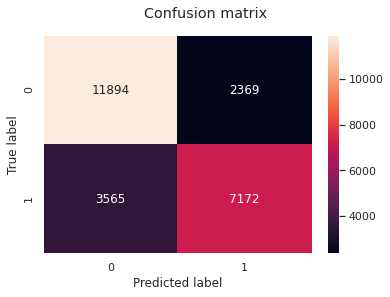

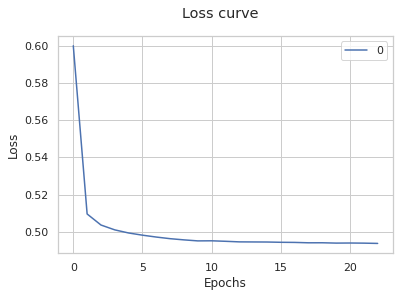

In [1252]:
mlp = MLPClassifier(
    max_iter=1000, 
    solver='adam',
    activation='tanh',
    hidden_layer_sizes=(12, 6, 2),
    n_iter_no_change=10,
    verbose=False,
    early_stopping=True
)
mlp.fit(X_train, y_train)
y_pred = mlp.predict_proba(X_test)[:, 1] > 0.57
accurancy = accuracy_score(y_test, y_pred)

# Print the results
print("Model with best params".center(70, "."))
print(">>> Accurancy:", accurancy)
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
)
plt.suptitle("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

pd.DataFrame(mlp.loss_curve_).plot()
plt.suptitle("Loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

## Model for tests

In this model I set different values for params and check which model performs better.

...........................Model for tests............................
>>> Accurancy: 0.76136


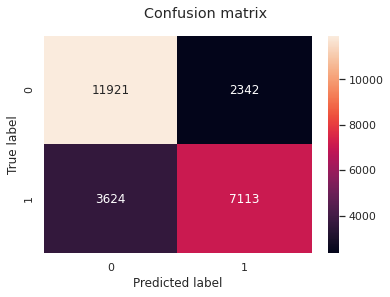

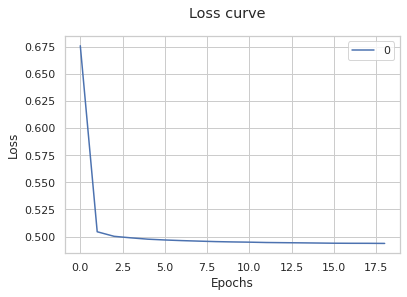

In [1254]:
mlp = MLPClassifier(
    max_iter=1000, 
    solver='adam',
    activation='relu',
    hidden_layer_sizes=(12, 6, 2),
    n_iter_no_change=10,
    verbose=False,
    early_stopping=True
)
mlp.fit(X_train, y_train)
y_pred = mlp.predict_proba(X_test)[:, 1] > 0.57
accurancy = accuracy_score(y_test, y_pred)

# Print the results
print("Model for tests".center(70, "."))
print(">>> Accurancy:", accurancy)
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt='d',
)
plt.suptitle("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

pd.DataFrame(mlp.loss_curve_).plot()
plt.suptitle("Loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

# Train dataset

To train our final model, we will use the entire dataset. But for this, we should do a few things.

In [1255]:
train_dataset = dataset_prepare.copy()
train_dataset.tail()

,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Embarked_C,Embarked_Q,Embarked_S
99995,1,1,62.0,14.86,0,1,0,1,0,0,1,0,0
99996,0,0,66.0,11.15,0,1,0,1,0,0,0,0,1
99997,0,0,37.0,9.95,0,0,1,1,0,0,0,0,1
99998,0,0,51.0,30.92,0,0,1,0,1,0,0,0,1
99999,0,0,55.0,13.96,0,0,1,1,0,0,0,0,1


And now, we can do what we did when we evaluate the model. I'm talking about column 'Fare' and 'Age'.

In [1256]:
train_dataset = train_dataset.drop(train_dataset[(train_dataset['Fare'] > 585) & (train_dataset['Survived'] == 0)].index)
train_dataset = train_dataset.drop(train_dataset[(train_dataset['Age'] > 81) & (train_dataset['Survived'] == 0)].index)

Split dataset to features(X) and labels(y).

In [1257]:
y_train = train_dataset.pop('Survived')
X_train = train_dataset.values

And new scaler for entire dataset:

In [1258]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 

# Test dataset

First, let's load the test dataset:

In [1259]:
test_dataset = pd.read_csv(url_test)
test_dataset.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C
99999,199999,1,"Fishback, Joanna",female,41.0,0,2,PC 41824,195.41,E13345,C


And now we should do exactly the same, what we did with train dataset.

I'll summarize all operations to one cell.

In [1260]:
# Columns: PassengerId, Name, SibSp, Ticket, Cabin
test_dataset = test_dataset.drop(['PassengerId', 'Name',  'Ticket', 'SibSp', 'Cabin'], axis=1)

# Column: Pclass
test_dataset = pd.get_dummies(
    test_dataset,
    columns=['Pclass']
)

# Column: Sex
test_dataset['Sex'] = test_dataset['Sex'].map({
    'female': 1, 
    'male': 0
})

# Column: Parch
test_dataset['Parch'] = test_dataset['Parch'].map({
    0: 0, 
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 2,
    6: 2,
    9: 2,
})
test_dataset = pd.get_dummies(
    test_dataset,
    columns=['Parch']
)

# Columns: Age, Fare
test_dataset['Age'].replace({np.nan: np.nanpercentile(test_dataset['Age'], 50) }, inplace=True)
test_dataset['Fare'].replace({np.nan: np.nanpercentile(test_dataset['Fare'], 50) }, inplace=True)

# Column: Embarked
test_dataset['Embarked'].replace({np.nan : "M"}, inplace=True)
test_dataset = pd.get_dummies(
    test_dataset,
    columns=['Embarked']
)
test_dataset = test_dataset.drop(['Embarked_M'], axis=1)

test_dataset.tail()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Parch_0,Parch_1,Parch_2,Embarked_C,Embarked_Q,Embarked_S
99995,1,27.0,10.12,0,0,1,1,0,0,0,1,0
99996,0,59.0,68.31,1,0,0,1,0,0,0,0,1
99997,0,47.0,10.87,0,0,1,1,0,0,0,0,1
99998,1,49.0,29.68,1,0,0,0,0,1,1,0,0
99999,1,41.0,195.41,1,0,0,0,0,1,1,0,0


And the last step is mounting the scaler:

In [1261]:
X_test = scaler.transform(test_dataset) 

# Final model: MLP Classifier

Final model is built based on the best model from "Evaluate Model".



In [1291]:
model = MLPClassifier(
    max_iter=1000, 
    solver='adam',
    activation='tanh',
    hidden_layer_sizes=(12, 6, 2),
    n_iter_no_change=10,
    verbose=False,
    early_stopping=True
)

For training I will use data from "Train dataset" section.


In [1292]:
model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(12, 6, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

# Results

Before we start predictions, let's look at sample submission:

In [1272]:
sample_submission = pd.read_csv(url_sample_submission, index_col='PassengerId')
sample_submission.tail()

,Survived
PassengerId,
199995,1
199996,1
199997,1
199998,1
199999,1


Now we know how submission should looks like.

Now we can make predictions. Let's do it!


In [1293]:
y_pred = model.predict_proba(X_test)[:,1]
y_pred_df = pd.DataFrame(y_pred, columns=['Survived'])

Survival rate is recorded into dataframe, and now, we can take a look into predictions.

When competition was started, in leaderboard appeared sample submission with accurnacy ~35%. We know that in sample submission everyone survived. So, we know that in our submission should be ~35 000 survivors. And code below is to regulate it. When you change threshold and run cell, it should display how many survivors you have in your dataset.

No. Survived    34568
dtype: int64


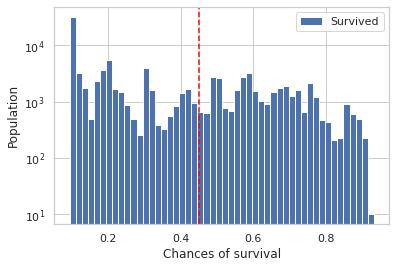

In [1296]:
# You can check different thresholds
threshold = 0.45

# Number of survived
print("No.", y_pred_df[y_pred_df['Survived'] > threshold].count())

# Plot
y_pred_df.plot(kind='hist', bins=50, log=True)
plt.axvline(threshold, linestyle='dashed', c='red')
plt.xlabel("Chances of survival")
plt.ylabel("Population")
plt.show()

And now, we can save our predictions into file. 

In [1297]:
results_df = (y_pred_df['Survived'] > threshold).astype(int)
results_df.columns = ['Survived']
results_df.index += 100000
results_df.index.name = 'PassengerId'
results_df.to_csv('submission.csv')
results_df.tail()

PassengerId
199995    1
199996    0
199997    0
199998    1
199999    1
Name: Survived, dtype: int64

# Summary of the project

My best accuracy in submision was:

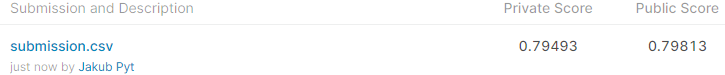